# Prediction of the larva's trajectory from the kinematics of tail movements



Author: [Adrien Jouary](http://www.ibens.ens.fr/spip.php?rubrique23&lang=fr)
To be published

DOI: ??? URL: <http://???>/


This [Jupyter](http://jupyter.org/) notebook is an electronic supplementry material of the article.


## Load configuration, function and plotting style configuration

In [16]:
%run  SystemIdent.py
%matplotlib inline

## Load trajectory and associated tail deflection

In [17]:
lib = open('../Data/LibrarySwimBout.save', 'rb')
Larva = []
NumSwimBout=306
for i in range(0,NumSwimBout):
    Larva.append(pickle.load(lib))#cPickle.load(fil))

lib.close()

<function __main__.PltFig>

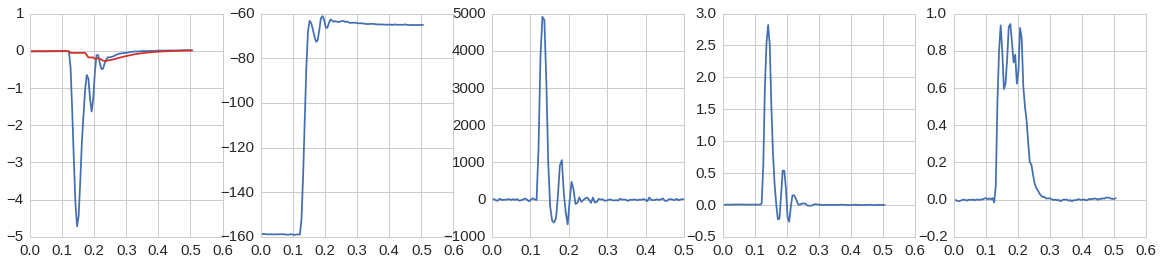

In [18]:
def PltFig(k):
    Time=np.linspace(0,len(Larva[k].TailCurv)*1/200.,len(Larva[k].TailCurv))
    plt.figure(figsize=(20,4));
    plt.subplot(1,5,1)
    plt.plot(Time,Larva[k].TailCurv,color=Bl)
    plt.plot(Time,Larva[k].AvgCurv,color=Re)
    plt.subplot(1,5,2)
    plt.plot(Time,Larva[k].HeadAngle*180/3.14,color=Bl)
    plt.subplot(1,5,3)
    plt.plot(Time[0:-1],np.diff(Larva[k].HeadAngle)*180/3.14*200,color=Bl)
    plt.subplot(1,5,4)
    plt.plot(Time,Larva[k].LateralMvt*200,color=Bl)
    plt.subplot(1,5,5)
    plt.plot(Time,Larva[k].AxialMvt*200,color=Bl)
    
interact(PltFig,k=(0,NumSwimBout-1,1))

In [19]:
from random import *

IndTrain=list(range(0,210,1)) + list(range(264,296,1))#list(range(0,50,1))#
IndTest=list(range(211,264,1)) + list(range(296,306,1))#list(range(50,60,1))


# System identification

## Fitting Kinematic Parameters from Tail Curvature on Train Dataset

In [20]:
nxHeadAngleDiff=7;nyHeadAngleDiff=7
nxLateralMvt=7;nyLateralMvt=7;
nxAxialMvt=20;nyAxialMvt=7;


for i in IndTrain:
    
            x=Larva[i].TailCurv-Larva[i].AvgCurv
            xabs=abs(np.hstack([np.zeros([1]),np.diff(Larva[i].TailCurv)]))
            
            yHeadAngleDiff=np.hstack([np.zeros([1]),np.diff(Larva[i].HeadAngle)])
            MatfHeadAngleDiff=ARXMat(x,nxHeadAngleDiff,yHeadAngleDiff,nyHeadAngleDiff)
            
            yLateralMvt=Larva[i].LateralMvt
            MatfLateralMvt=ARXMat(x,nxLateralMvt,yLateralMvt,nyLateralMvt)
            
            yAxialMvt=Larva[i].AxialMvt
            MatfAxialMvt=ARXMat(xabs,nxAxialMvt,yAxialMvt,nyAxialMvt)
            
            if i==IndTrain[0]:
                xtot=x
                xabstot=x
                MatHeadAngleDiff=MatfHeadAngleDiff
                MatLateralMvt=MatfLateralMvt
                MatAxialMvt=MatfAxialMvt
                ytotHeadAngleDiff=yHeadAngleDiff
                ytotLateralMvt=yLateralMvt
                ytotAxialMvt=yAxialMvt
                
            else:
                xtot=np.hstack([xtot,x])
                xabstot=np.hstack([xabstot,xabs])
                MatHeadAngleDiff=np.vstack([MatHeadAngleDiff,MatfHeadAngleDiff])
                ytotHeadAngleDiff=np.hstack([ytotHeadAngleDiff,yHeadAngleDiff])
                
                MatLateralMvt=np.vstack([MatLateralMvt,MatfLateralMvt])
                ytotLateralMvt=np.hstack([ytotLateralMvt,yLateralMvt])
                
                MatAxialMvt=np.vstack([MatAxialMvt,MatfAxialMvt])
                ytotAxialMvt=np.hstack([ytotAxialMvt,yAxialMvt])
                
ParaHeadAngleDiff=RegressARX(MatHeadAngleDiff,ytotHeadAngleDiff)
R2_HeadAngle=GoodnessOfFit(xtot,ytotHeadAngleDiff,ParaHeadAngleDiff,nxHeadAngleDiff,nyHeadAngleDiff)

ParaLateralMvt=RegressARX(MatLateralMvt,ytotLateralMvt)
R2_LateralMvt=GoodnessOfFit(xtot,ytotLateralMvt,ParaLateralMvt,nxLateralMvt,nyLateralMvt)

ParaAxialMvt=RegressARX(MatAxialMvt,ytotAxialMvt)
R2_AxialMvt=GoodnessOfFit(xabstot,ytotAxialMvt,ParaAxialMvt,nxAxialMvt,nyAxialMvt)

Sys=Model(ParaHeadAngleDiff,nxHeadAngleDiff,nxHeadAngleDiff,ParaLateralMvt,nxLateralMvt,nyLateralMvt,ParaAxialMvt,nxAxialMvt,nyAxialMvt)

In [21]:
print(R2_LateralMvt)
print(R2_AxialMvt)
print(R2_HeadAngle)


0.66733226512
0.793867099332
0.718813135947


 On the test set that we considered, the value obtain for the goodness of fit were $R^2_{Lateral}=0.67$, $R^2_{Axial}=0.79$ and $R^2_{Yaw}=0.72$. 

# Accessing the result in kinematic parameters from tail curvature on Test Dataset

## Compute Trajectory of test dataset using Tail Curvature

In [22]:
# Make function compute trajectory from Tail Curvature
LarvaSim={}

for i in range(0,len(IndTest)):
    k=IndTest[i]
    
    x=Larva[k].TailCurv-Larva[k].AvgCurv
    xabs=abs(np.hstack([np.zeros([1]),np.diff(Larva[k].TailCurv)]))
    t=np.arange(0,len(x)/200.,1./200.)
    
    HeadPos=Larva[k].HeadPos#*Larva[k].LarvaLen/0.2 
    Vect=Larva[k].HeadVect
    NumFrames=Larva[k].NumFrames

    HeadAngleSim=np.cumsum(Sim(x,Sys.ParaHeadAngleDiff,Sys.nxHeadAngleDiff,Sys.nyHeadAngleDiff,0))+Larva[k].HeadAngle[0]
    
    Lat=Sim(x,Sys.ParaLateralMvt,Sys.nxLateralMvt,Sys.nyLateralMvt,Larva[i].LateralMvt[0])
    Axi=Sim(xabs,Sys.ParaAxialMvt,Sys.nxAxialMvt,Sys.nyAxialMvt,Larva[i].AxialMvt[0])
    

    
    Phi=np.arctan2(Lat,Axi)
    HeadPosSim=np.zeros([2,NumFrames])
    HeadVectSim=np.zeros([2,NumFrames],np.dtype(float))
    
    HeadPosSim[:,0]=Larva[k].HeadPos[:,0]
    
    for j in range(1,NumFrames):
        
        a=sqrt(Lat[j]**2+Axi[j]**2)#*Larva[k].LarvaLen/0.2
        b=np.array([[np.cos(Phi[j]+Larva[k].HeadAngle[j])],[np.sin(Phi[j]+Larva[k].HeadAngle[j])]])
        HeadPosSim[0,j]=HeadPosSim[0,j-1]+a*b[0][0]
        HeadPosSim[1,j]=HeadPosSim[1,j-1]+a*b[1][0]
        HeadVectSim[0,j]=np.cos((HeadAngleSim[j]))
        HeadVectSim[1,j]=np.sin((HeadAngleSim[j]))

    LarvaSim[i]=LarvaSwimBout(Larva[k].TailCurv,Larva[k].AvgCurv,HeadAngleSim,HeadPosSim,HeadVectSim,NumFrames,Larva[k].NumFilm,Larva[k].LarvaLen)

/home/adrien/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
/home/adrien/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:33: ComplexWarning: Casting complex values to real discards the imaginary part


242


<function __main__.PltFig>

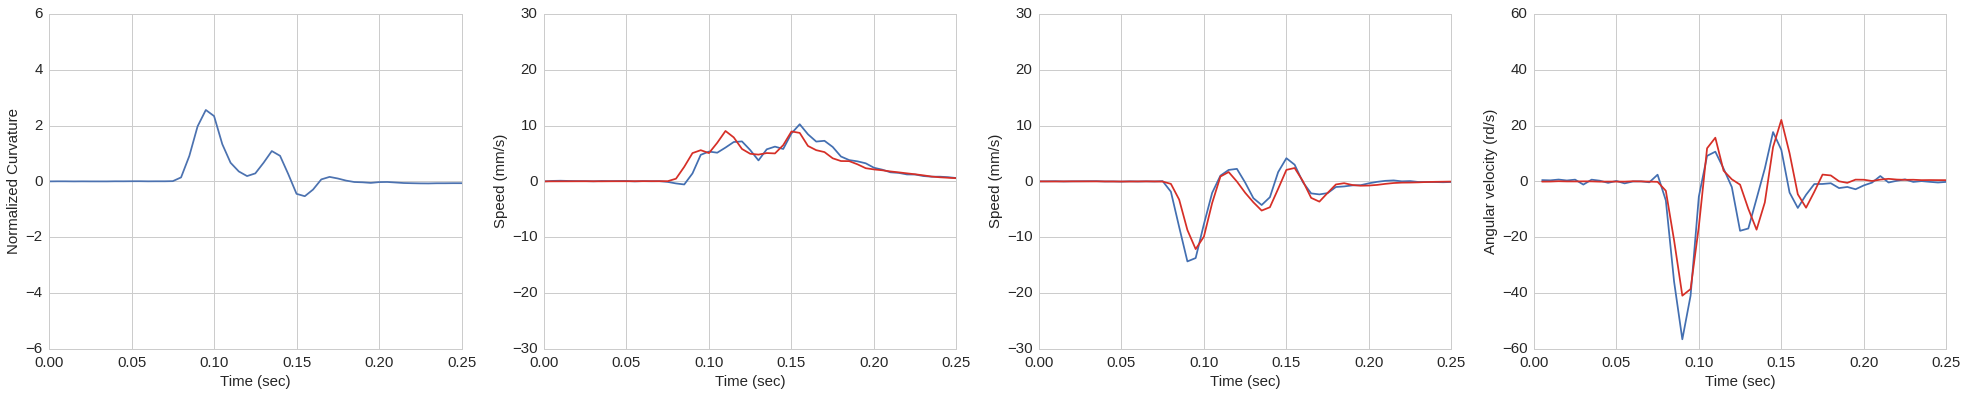

In [23]:

def PltFig(i):
    k=IndTest[i]
    t=np.arange(0,Larva[k].NumFrames/200.,1./200.)
    plt.figure(figsize=(34,6));
    plt.subplot(1,4,1)
    plt.plot(t,Larva[k].TailCurv-Larva[k].AvgCurv,label='Tail Curvature')
    plt.ylim([-6,6])
    plt.xlim([0,0.25])
    plt.xlabel('Time (sec)')
    plt.ylabel('Normalized Curvature')
    plt.subplot(1,4,2)
    plt.plot(t,10*Larva[k].AxialMvt/(0.005),color=Bl,label="Axial Mvt") #
    plt.plot(t,10*LarvaSim[i].AxialMvt/(0.005),color=Re,label="Reconstruction")
    plt.xlabel('Time (sec)')
    plt.ylabel('Speed (mm/s)')
    plt.ylim([-30,30])
    plt.xlim([0,0.25])
    plt.subplot(1,4,3)
    plt.plot(t,10*Larva[k].LateralMvt/(0.005),color=Bl,label="Lateral Mvt")
    plt.plot(t,10*LarvaSim[i].LateralMvt/(0.005),color=Re,label="Reconstruction")
    plt.xlabel('Time (sec)')
    plt.ylabel('Speed (mm/s)')
    plt.ylim([-30,30])
    plt.xlim([0,0.25])
    plt.subplot(1,4,4)
    plt.plot(t[1:],np.diff(Larva[k].HeadAngle)*(pi/pi)/(0.005),color=Bl,label="HeadAngle")
    plt.plot(t[1:],np.diff(LarvaSim[i].HeadAngle)*(pi/pi)/0.005,color=Re,label="Reconstruction")
    plt.xlabel('Time (sec)')
    plt.ylabel('Angular velocity (rd/s)')
    plt.ylim([-60,60])
    plt.xlim([0,0.25])
    print(k)
interact(PltFig,i=(0,len(IndTest)-1,1))

## Show Trajectory

<function __main__.PltFig>

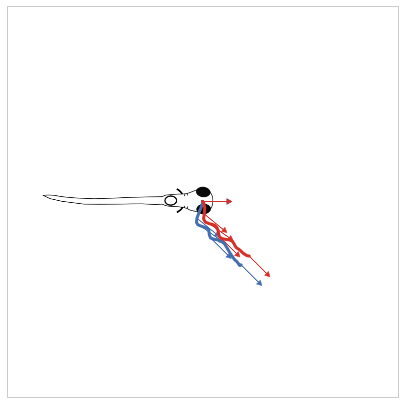

In [24]:
def PltFig(i):
    import numpy.matlib
    k=IndTest[i]
    # Plot trajectory & HeadAngle
    fig =plt.figure(figsize=(7,7)); 
    plt.xticks([])
    plt.yticks([])
    ax = fig.add_subplot(111)

    img=plt.imread("../Data/Fish.png")
    Center=np.array([0,0])
    plt.imshow(img, cmap=plt.cm.gray, extent=[-img.shape[1]/2,img.shape[1]/2,-img.shape[0]/2, img.shape[0]/2])
    
    Larva[k].HeadPos[0,:]=Larva[k].HeadPos[0,:]-Larva[k].HeadPos[0,0]
    Larva[k].HeadPos[1,:]=Larva[k].HeadPos[1,:]-Larva[k].HeadPos[1,0]
    LarvaSim[i].HeadPos[0,:]=LarvaSim[i].HeadPos[0,:]-LarvaSim[i].HeadPos[0,0]
    LarvaSim[i].HeadPos[1,:]=LarvaSim[i].HeadPos[1,:]-LarvaSim[i].HeadPos[1,0]
    
    
    PosRot=rot((Larva[k].HeadPos)*Larva[k].LarvaLen/0.2,-Larva[k].HeadAngle[0],np.array([0,0]))
    PosSimRot=rot(LarvaSim[i].HeadPos*LarvaSim[i].LarvaLen/0.2,-LarvaSim[i].HeadAngle[0],Center)

    VectRot=rot(Larva[k].HeadVect,-Larva[k].HeadAngle[0],np.zeros(Center.shape))
    VectSimRot=rot(LarvaSim[i].HeadVect,-LarvaSim[i].HeadAngle[0],np.zeros(Center.shape))
    
    
    ax.plot(PosRot[0,:],PosRot[1,:],color=Bl,lw=3,label="True Trajectory")
    ax.plot(PosSimRot[0,:],PosSimRot[1,:],color=Re,lw=3,label="Trajectory reconstructed from tail movement")

    ax.set_xlim([PosRot[0,0] -400,PosRot[0,0] +400])
    ax.set_ylim([PosRot[1,0] -400,PosRot[1,0] +400])
    
    for j in range(0,Larva[k].NumFrames):
    
        if j==0 or j==Larva[k].NumFrames-1 or ((np.mod(j,3)==1) and ((Larva[k].TailCurv[j]-Larva[k].AvgCurv[j])>0.5)):
            
            plt.arrow(PosRot[0,j],PosRot[1,j],50*VectRot[0,j],50*VectRot[1,j], head_width=11, head_length=10, fc=Bl, ec=Bl,linewidth=0.5)
            
            plt.arrow(PosSimRot[0,j],PosSimRot[1,j],50*VectRot[0,j],50*VectRot[1,j], head_width=11, head_length=10, fc=Re, ec=Re,linewidth=0.5)
    
               
interact(PltFig,i=(0,len(IndTest)-1,1))
